# Setting and defining standards/patterns

In [1]:
import gc
import sys
import warnings
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)



# Loading and joining the data

In [2]:
data_dir = Path('../input/mlb-player-digital-engagement-forecasting/')
training = pd.read_csv(data_dir / 'train.csv')

# Convert training data date field to datetime type
training['date'] = pd.to_datetime(training['date'], format="%Y%m%d")

display(training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1216 non-null   datetime64[ns]
 1   nextDayPlayerEngagement  1216 non-null   object        
 2   games                    639 non-null    object        
 3   rosters                  1216 non-null   object        
 4   playerBoxScores          538 non-null    object        
 5   teamBoxScores            538 non-null    object        
 6   transactions             1103 non-null   object        
 7   standings                531 non-null    object        
 8   awards                   294 non-null    object        
 9   events                   536 non-null    object        
 10  playerTwitterFollowers   40 non-null     object        
 11  teamTwitterFollowers     40 non-null     object        
dtypes: datetime64[ns](1), object(11)
m

None

In [3]:
#### Look at data from each of the input dfs read in ####
df_names = ['seasons', 'teams', 'players', 'awards']

for name in df_names:
    globals()[name] = pd.read_csv(data_dir / f"{name}.csv")

kaggle_data_tabs = widgets.Tab()
# Add Output widgets for each pandas DF as tabs' children
kaggle_data_tabs.children = list([widgets.Output() for df_name in df_names])

for index in range(0, len(df_names)):
    # Rename tab bar titles to df names
    kaggle_data_tabs.set_title(index, df_names[index])
    
    # Display corresponding table output for this tab name
    with kaggle_data_tabs.children[index]:
        display(eval(df_names[index]))

display(kaggle_data_tabs)



# Structuring data into player_engagement_with_info dataframe

In [4]:
# Helper function to unpack json found in daily data
def unpack_json(json_str):
    return np.nan if pd.isna(json_str) else pd.read_json(json_str)

#### Unnest various nested data within training (daily) data ####
daily_data_unnested_dfs = pd.DataFrame(data = {
  'dfName': training.drop('date', axis = 1).columns.values.tolist() 
  })

daily_data_unnested_dfs['df'] = [pd.DataFrame() for row in 
  daily_data_unnested_dfs.iterrows()]

for df_index, df_row in daily_data_unnested_dfs.iterrows():
    nestedTableName = str(df_row['dfName'])
    
    date_nested_table = training[['date', nestedTableName]]
    
    date_nested_table = (date_nested_table[
      ~pd.isna(date_nested_table[nestedTableName])
      ].
      reset_index(drop = True)
      )
    
    daily_dfs_collection = []
    
    for date_index, date_row in date_nested_table.iterrows():
        daily_df = unpack_json(date_row[nestedTableName])
        
        daily_df['dailyDataDate'] = date_row['date']
        
        daily_dfs_collection = daily_dfs_collection + [daily_df]

    unnested_table = pd.concat(daily_dfs_collection,
      ignore_index = True).set_index('dailyDataDate').reset_index()

    # Creates 1 pandas df per unnested df from daily data read in, with same name
    globals()[df_row['dfName']] = unnested_table    
    
    daily_data_unnested_dfs['df'][df_index] = unnested_table

del training
gc.collect()



#### Get some information on each date in daily data (using season dates of interest) ####
dates = pd.DataFrame(data = 
  {'dailyDataDate': nextDayPlayerEngagement['dailyDataDate'].unique()})

dates['date'] = pd.to_datetime(dates['dailyDataDate'].astype(str))

dates['year'] = dates['date'].dt.year
dates['month'] = dates['date'].dt.month

dates_with_info = pd.merge(
  dates,
  seasons,
  left_on = 'year',
  right_on = 'seasonId'
  )

dates_with_info['inSeason'] = (
  dates_with_info['date'].between(
    dates_with_info['regularSeasonStartDate'],
    dates_with_info['postSeasonEndDate'],
    inclusive = True
    )
  )

dates_with_info['seasonPart'] = np.select(
  [
    dates_with_info['date'] < dates_with_info['preSeasonStartDate'], 
    dates_with_info['date'] < dates_with_info['regularSeasonStartDate'],
    dates_with_info['date'] <= dates_with_info['lastDate1stHalf'],
    dates_with_info['date'] < dates_with_info['firstDate2ndHalf'],
    dates_with_info['date'] <= dates_with_info['regularSeasonEndDate'],
    dates_with_info['date'] < dates_with_info['postSeasonStartDate'],
    dates_with_info['date'] <= dates_with_info['postSeasonEndDate'],
    dates_with_info['date'] > dates_with_info['postSeasonEndDate']
  ], 
  [
    'Offseason',
    'Preseason',
    'Reg Season 1st Half',
    'All-Star Break',
    'Reg Season 2nd Half',
    'Between Reg and Postseason',
    'Postseason',
    'Offseason'
  ], 
  default = np.nan
  )

#### Add some pitching stats/pieces of info to player game level stats ####

player_game_stats = (playerBoxScores.copy().
  # Change team Id/name to reflect these come from player game, not roster
  rename(columns = {'teamId': 'gameTeamId', 'teamName': 'gameTeamName'})
  )

# Adds in field for innings pitched as fraction (better for aggregation)
player_game_stats['inningsPitchedAsFrac'] = np.where(
  pd.isna(player_game_stats['inningsPitched']),
  np.nan,
  np.floor(player_game_stats['inningsPitched']) +
    (player_game_stats['inningsPitched'] -
      np.floor(player_game_stats['inningsPitched'])) * 10/3
  )

# Add in Tom Tango pitching game score (https://www.mlb.com/glossary/advanced-stats/game-score)
player_game_stats['pitchingGameScore'] = (40
#     + 2 * player_game_stats['outs']
    + 1 * player_game_stats['strikeOutsPitching']
    - 2 * player_game_stats['baseOnBallsPitching']
    - 2 * player_game_stats['hitsPitching']
    - 3 * player_game_stats['runsPitching']
    - 6 * player_game_stats['homeRunsPitching']
    )

# Add in criteria for no-hitter by pitcher (individual, not multiple pitchers)
player_game_stats['noHitter'] = np.where(
  (player_game_stats['gamesStartedPitching'] == 1) &
  (player_game_stats['inningsPitched'] >= 9) &
  (player_game_stats['hitsPitching'] == 0),
  1, 0
  )

player_date_stats_agg = pd.merge(
  (player_game_stats.
    groupby(['dailyDataDate', 'playerId'], as_index = False).
    # Some aggregations that are not simple sums
    agg(
      numGames = ('gamePk', 'nunique'),
      # Should be 1 team per player per day, but adding here for 1 exception:
      # playerId 518617 (Jake Diekman) had 2 games for different teams marked
      # as played on 5/19/19, due to resumption of game after he was traded
      numTeams = ('gameTeamId', 'nunique'),
      # Should be only 1 team for almost all player-dates, taking min to simplify
      gameTeamId = ('gameTeamId', 'min')
      )
    ),
  # Merge with a bunch of player stats that can be summed at date/player level
  (player_game_stats.
    groupby(['dailyDataDate', 'playerId'], as_index = False)
    [['runsScored', 'homeRuns', 'strikeOuts', 'baseOnBalls', 'hits',
      'hitByPitch', 'atBats', 'caughtStealing', 'stolenBases',
      'groundIntoDoublePlay', 'groundIntoTriplePlay', 'plateAppearances',
      'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies',
      'gamesStartedPitching', 'runsPitching', 'homeRunsPitching', 
      'strikeOutsPitching', 'baseOnBallsPitching', 'hitsPitching',
      'inningsPitchedAsFrac', 'earnedRuns', 
      'battersFaced','saves', 'blownSaves', 'pitchingGameScore', 
      'noHitter'
      ]].
    sum()
    ),
  on = ['dailyDataDate', 'playerId'],
  how = 'inner'
  )

#### Turn games table into 1 row per team-game, then merge with team box scores ####
# Filter to regular or Postseason games w/ valid scores for this part
games_for_stats = games[
  np.isin(games['gameType'], ['R', 'F', 'D', 'L', 'W', 'C', 'P']) &
  ~pd.isna(games['homeScore']) &
  ~pd.isna(games['awayScore'])
  ]

# Get games table from home team perspective
games_home_perspective = games_for_stats.copy()

# Change column names so that "team" is "home", "opp" is "away"
games_home_perspective.columns = [
  col_value.replace('home', 'team').replace('away', 'opp') for 
    col_value in games_home_perspective.columns.values]

games_home_perspective['isHomeTeam'] = 1

# Get games table from away team perspective
games_away_perspective = games_for_stats.copy()

# Change column names so that "opp" is "home", "team" is "away"
games_away_perspective.columns = [
  col_value.replace('home', 'opp').replace('away', 'team') for 
    col_value in games_away_perspective.columns.values]

games_away_perspective['isHomeTeam'] = 0

# Put together games from home/away perspective to get df w/ 1 row per team game
team_games = (pd.concat([
  games_home_perspective,
  games_away_perspective
  ],
  ignore_index = True)
  )

# Copy over team box scores data to modify
team_game_stats = teamBoxScores.copy()

# Change column names to reflect these are all "team" stats - helps 
# to differentiate from individual player stats if/when joining later
team_game_stats.columns = [
  (col_value + 'Team') 
  if (col_value not in ['dailyDataDate', 'home', 'teamId', 'gamePk',
    'gameDate', 'gameTimeUTC'])
    else col_value
  for col_value in team_game_stats.columns.values
  ]

# Merge games table with team game stats
team_games_with_stats = pd.merge(
  team_games,
  team_game_stats.
    # Drop some fields that are already present in team_games table
    drop(['home', 'gameDate', 'gameTimeUTC'], axis = 1),
  on = ['dailyDataDate', 'gamePk', 'teamId'],
  # Doing this as 'inner' join excludes spring training games, postponed games,
  # etc. from original games table, but this may be fine for purposes here 
  how = 'inner'
  )

team_date_stats_agg = (team_games_with_stats.
  groupby(['dailyDataDate', 'teamId', 'gameType', 'oppId', 'oppName'], 
    as_index = False).
  agg(
    numGamesTeam = ('gamePk', 'nunique'),
    winsTeam = ('teamWinner', 'sum'),
    lossesTeam = ('oppWinner', 'sum'),
    runsScoredTeam = ('teamScore', 'sum'),
    runsAllowedTeam = ('oppScore', 'sum')
    )
   )

# Prepare standings table for merge w/ player digital engagement data
# Pick only certain fields of interest from standings for merge
standings_selected_fields = (standings[['dailyDataDate', 'teamId', 
  'streakCode', 'divisionRank', 'leagueRank', 'wildCardRank', 'pct'
  ]].
  rename(columns = {'pct': 'winPct'})
  )

# Change column names to reflect these are all "team" standings - helps 
# to differentiate from player-related fields if/when joining later
standings_selected_fields.columns = [
  (col_value + 'Team') 
  if (col_value not in ['dailyDataDate', 'teamId'])
    else col_value
  for col_value in standings_selected_fields.columns.values
  ]

standings_selected_fields['streakLengthTeam'] = (
  standings_selected_fields['streakCodeTeam'].
    str.replace('W', '').
    str.replace('L', '').
    astype(float)
    )

# Add fields to separate winning and losing streak from streak code
standings_selected_fields['winStreakTeam'] = np.where(
  standings_selected_fields['streakCodeTeam'].str[0] == 'W',
  standings_selected_fields['streakLengthTeam'],
  np.nan
  )

standings_selected_fields['lossStreakTeam'] = np.where(
  standings_selected_fields['streakCodeTeam'].str[0] == 'L',
  standings_selected_fields['streakLengthTeam'],
  np.nan
  )

standings_for_digital_engagement_merge = (pd.merge(
  standings_selected_fields,
  dates_with_info[['dailyDataDate', 'inSeason']],
  on = ['dailyDataDate'],
  how = 'left'
  ).
  # Limit down standings to only in season version
  query("inSeason").
  # Drop fields no longer necessary (in derived values, etc.)
  drop(['streakCodeTeam', 'streakLengthTeam', 'inSeason'], axis = 1).
  reset_index(drop = True)
  )

#### Merge together various data frames to add date, player, roster, and team info ####
# Copy over player engagement df to add various pieces to it
player_engagement_with_info = nextDayPlayerEngagement.copy()

# Take "row mean" across targets to add (helps with studying all 4 targets at once)
player_engagement_with_info['targetAvg'] = np.mean(
  player_engagement_with_info[['target1', 'target2', 'target3', 'target4']],
  axis = 1)

# Merge in date information
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  dates_with_info[['dailyDataDate', 'date', 'year', 'month', 'inSeason',
    'seasonPart']],
  on = ['dailyDataDate'],
  how = 'left'
  )

# Merge in some player information
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  players[['playerId', 'playerName', 'DOB', 'mlbDebutDate', 'birthCity',
    'birthStateProvince', 'birthCountry', 'primaryPositionName']],
   on = ['playerId'],
   how = 'left'
   )

# Merge in some player roster information by date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (rosters[['dailyDataDate', 'playerId', 'statusCode', 'status', 'teamId']].
    rename(columns = {
      'statusCode': 'rosterStatusCode',
      'status': 'rosterStatus',
      'teamId': 'rosterTeamId'
      })
    ),
  on = ['dailyDataDate', 'playerId'],
  how = 'left'
  )
    
# Merge in team name from player's roster team
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (teams[['id', 'teamName']].
    rename(columns = {
      'id': 'rosterTeamId',
      'teamName': 'rosterTeamName'
      })
    ),
  on = ['rosterTeamId'],
  how = 'left'
  )

# Merge in some player game stats (previously aggregated) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  player_date_stats_agg,
  on = ['dailyDataDate', 'playerId'],
  how = 'left'
  )

# Merge in team name from player's game team
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (teams[['id', 'teamName']].
    rename(columns = {
      'id': 'gameTeamId',
      'teamName': 'gameTeamName'
      })
    ),
  on = ['gameTeamId'],
  how = 'left'
  )

# Merge in some team game stats/results (previously aggregated) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  team_date_stats_agg.rename(columns = {'teamId': 'gameTeamId'}),
  on = ['dailyDataDate', 'gameTeamId'],
  how = 'left'
  )

# Merge in player transactions of note on that date
    
# Merge in some pieces of team standings (previously filter/processed) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  standings_for_digital_engagement_merge.
    rename(columns = {'teamId': 'gameTeamId'}),
  on = ['dailyDataDate', 'gameTeamId'],
  how = 'left'
  )

display(player_engagement_with_info)

,dailyDataDate,engagementMetricsDate,playerId,target1,target2,target3,target4,targetAvg,date,year,...,winsTeam,lossesTeam,runsScoredTeam,runsAllowedTeam,divisionRankTeam,leagueRankTeam,wildCardRankTeam,winPctTeam,winStreakTeam,lossStreakTeam
0,2018-01-01,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,2.556584,2018-01-01,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118,2.118882,2018-01-01,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667,33.752945,2018-01-01,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,2018-01-02,607625,0.006700,2.675097,0.005168,1.862745,1.137428,2018-01-01,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,2018-01-02,592547,0.001117,0.632296,0.002953,0.931373,0.391934,2018-01-01,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506171,2021-04-30,2021-05-01,451661,0.000000,0.013314,0.000000,0.625925,0.159810,2021-04-30,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2506172,2021-04-30,2021-05-01,519301,0.000131,0.003329,0.000000,0.216229,0.054922,2021-04-30,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2506173,2021-04-30,2021-05-01,527055,0.000000,0.019971,0.000000,0.273131,0.073276,2021-04-30,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2506174,2021-04-30,2021-05-01,543484,0.000131,0.056586,0.000000,1.024240,0.270239,2021-04-30,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Exploration

In [5]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual",
            "Semiannual",
            "Quarterly",
            "Bimonthly",
            "Monthly",
            "Biweekly",
            "Weekly",
            "Semiweekly",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Density")
    ax.set_title("Periodogram")
    return ax

# Seasonal plot - Time series

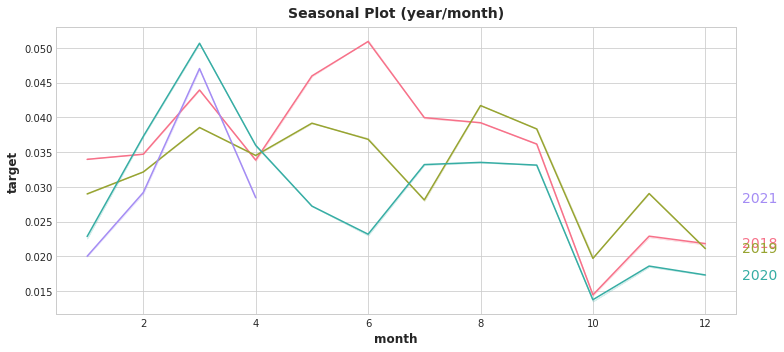

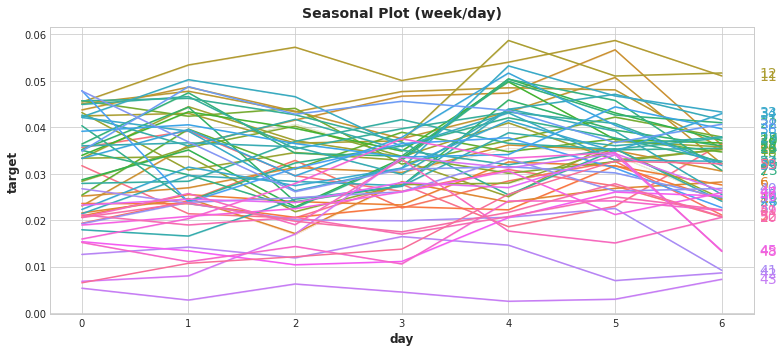

In [6]:
# Extract player engagement time series 
index = ["playerId", "date"]
targets = ["target1", "target2", "target3", "target4"]
Y = player_engagement_with_info.loc[:, index + targets]
Y = Y.assign(date=lambda x: pd.to_datetime(x.date))
Y = Y.set_index("date").to_period("D")
Y = Y.pivot(columns="playerId")

# Select Yankees players
yankees_players = player_engagement_with_info.query("rosterTeamName == 'Yankees'").playerId.unique()
yankees = Y.loc(axis=1)[:, yankees_players]

# Create average engagement series
team = (yankees / yankees.max(axis=0)).mean(axis=1)
team.name = "target"

# Yearly plot
S = team.to_frame()
S["month"] = S.index.month  # the frequency
S["year"] = S.index.year  # the period
_ = seasonal_plot(S, y="target", period="year", freq="month")

# Weekly plot
S = team.to_frame()
S["day"] = S.index.dayofweek  # the frequency
S["week"] = S.index.week  # the period
_ = seasonal_plot(S, y="target", period="week", freq="day")

# Periodogram

 Illustrates the strength of the frequencies within a signal -- specifically, the variance of the sine / cosine Fourier component oscillating at that frequency.

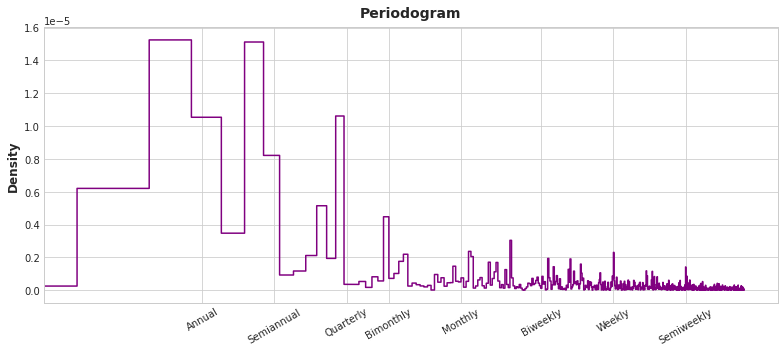

In [7]:
_ = plot_periodogram(team)



# Data Pipeline

In [10]:
#select a set of features from player_engagement_with_info
#pivot the dataframe from long to wide format so that each column comprises a time series for the training period
#create Fourier features to model the annual seasonality
#split data into training and validation sets

df = player_engagement_with_info

# Columns to select
index = ["playerId", "date"]
targets = ["target1", "target2", "target3", "target4"]
features = [
    "runsScored", "hits", "stolenBases", "rbi", "atBats", "saves", "homeRuns",
    "stolenBases", "strikeOuts",
]

# Targets
Y = df.loc[:, index + targets]
Y = Y.assign(date=lambda x: pd.to_datetime(x.date))
Y = Y.set_index("date").to_period("D")
Y = Y.pivot(columns="playerId")

# Features
X = df.loc[:, index + features].set_index("date").to_period("D")
for col in features:
    X[col] = X[col].fillna(-1)
X = X.pivot(columns=["playerId"])

# Temporal features
fourier = CalendarFourier(freq='A', order=8)
deterministic = DeterministicProcess(
    index=X.index,
    order=0,
    seasonal=False,  # set to True to create indicators for days of the week (weekly seasonality)
    additional_terms=[fourier],
)
X = pd.concat([X, deterministic.in_sample()], axis=1)

# Training splits
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    Y,
    test_size=30,  # 30-day validation set
    shuffle=False,
)

# Model creation

In [11]:
OUTPUTS = y_train.shape[-1]
early_stopping = keras.callbacks.EarlyStopping(patience=5,
                                               restore_best_weights=True)

model = keras.Sequential([
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(OUTPUTS),
])

In [12]:
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
38/38 [==============================] - 10s 222ms/step - loss: 1.3647 - mae: 1.3647 - val_loss: 7.9043 - val_mae: 7.9043
Epoch 2/50
38/38 [==============================] - 8s 201ms/step - loss: 1.2496 - mae: 1.2496 - val_loss: 4.1119 - val_mae: 4.1119
Epoch 3/50
38/38 [==============================] - 8s 200ms/step - loss: 1.1417 - mae: 1.1417 - val_loss: 2.0755 - val_mae: 2.0755
Epoch 4/50
38/38 [==============================] - 8s 207ms/step - loss: 1.0717 - mae: 1.0717 - val_loss: 1.2136 - val_mae: 1.2136
Epoch 5/50
38/38 [==============================] - 8s 204ms/step - loss: 1.0360 - mae: 1.0360 - val_loss: 1.1138 - val_mae: 1.1138
Epoch 6/50
38/38 [==============================] - 8s 202ms/step - loss: 1.0185 - mae: 1.0185 - val_loss: 1.0822 - val_mae: 1.0822
Epoch 7/50
38/38 [==============================] - 8s 201ms/step - loss: 1.0117 - mae: 1.0117 - val_loss: 1.1443 - val_mae: 1.1443
Epoch 8/50
38/38 [==============================] - 8s 204ms/step - loss: 1

# Evaluate

In [13]:
y_eval = model.predict(X_valid)
y_eval = pd.DataFrame(y_eval,
                      index=y_valid.index,
                      columns=y_valid.columns)
y_fit = model.predict(X_train)
y_fit = pd.DataFrame(y_fit,
                     index=y_train.index,
                     columns=y_train.columns)

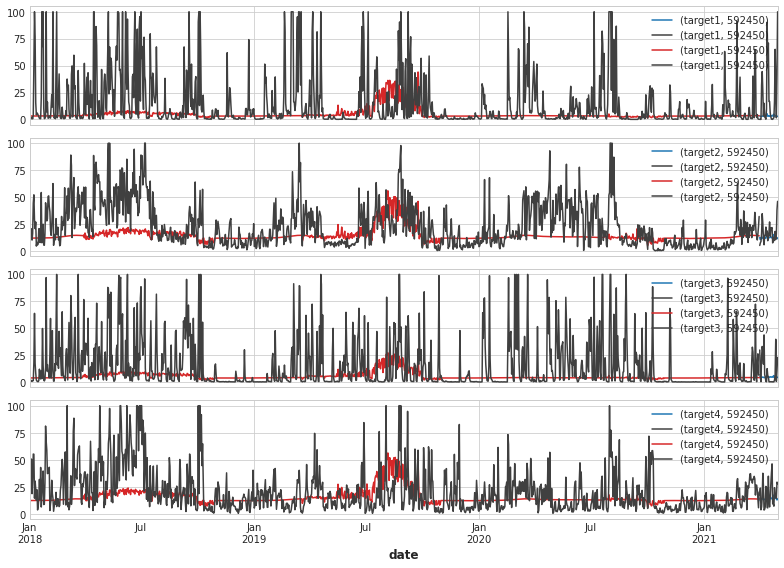

In [14]:
player = 592450  # Aaron Judge of the NY Yankees
fig, ax = plt.subplots(figsize=(11, 8))
ax = y_eval.loc(axis=1)[:, player].plot(ax=ax, subplots=True, color='C0')
ax = y_valid.loc(axis=1)[:, player].plot(subplots=True,
                                         sharex=True,
                                         ax=ax,
                                         color='0.25')
ax = y_fit.loc(axis=1)[:, player].plot(subplots=True,
                                       sharex=True,
                                       ax=ax,
                                       color='C3')
ax = y_train.loc(axis=1)[:, player].plot(subplots=True,
                                         sharex=True,
                                         ax=ax,
                                         color='0.25')

